# AirBnb Data Project
This project consists of the following:
1) Downloading listing data
2) Cleaning the raw data
3) Inserting the cleaned data into a SQL database
4) Exploring the data via SQL

## Data Exploration / Cleaning

In [110]:
import pandas as pd

In [111]:
#importing in the air bnb data, which was scrapped for nyc march 2025
datapath = 'data/'
dirty_data = 'nyc_airbnb_listings_march.csv'

#analyzing the different columns
dirty_df = pd.read_csv(datapath+dirty_data)
dirty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37434 entries, 0 to 37433
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            37434 non-null  float64
 1   listing_url                                   37434 non-null  object 
 2   scrape_id                                     37434 non-null  float64
 3   last_scraped                                  37434 non-null  object 
 4   source                                        37434 non-null  object 
 5   name                                          37432 non-null  object 
 6   description                                   36441 non-null  object 
 7   neighborhood_overview                         20224 non-null  object 
 8   picture_url                                   37433 non-null  object 
 9   host_id                                       37434 non-null 

In [112]:
#deciding which columns to keep, based on a subjective analysis of what information is useful
kept_indices= [0,9,18,26,28,29,30,31,33,35,37,38,40,56,65]

#illustrating which columns where kept vs dropped
all_columns = dirty_df.columns.tolist()
kept_columns = [all_columns[i] for i in kept_indices]
dropped_columns = [col for col in all_columns if col not in kept_columns]

comparison_df = pd.DataFrame({
    'Kept Columns' : pd.Series(kept_columns),
    'Dropped Columns' : pd.Series(dropped_columns)
})

comparison_df.fillna('', inplace=True)
comparison_df

,Kept Columns,Dropped Columns
0,id,listing_url
1,host_id,scrape_id
2,host_is_superhost,last_scraped
3,host_identity_verified,source
4,neighbourhood_cleansed,name
...,...,...
59,,calculated_host_listings_count
60,,calculated_host_listings_count_entire_homes
61,,calculated_host_listings_count_private_rooms
62,,calculated_host_listings_count_shared_rooms


In [113]:
#filter the df
df_filtered  = dirty_df.iloc[:,kept_indices]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37434 entries, 0 to 37433
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            37434 non-null  float64
 1   host_id                       37434 non-null  int64  
 2   host_is_superhost             36994 non-null  object 
 3   host_identity_verified        37396 non-null  object 
 4   neighbourhood_cleansed        37434 non-null  object 
 5   neighbourhood_group_cleansed  37434 non-null  object 
 6   latitude                      37434 non-null  float64
 7   longitude                     37434 non-null  float64
 8   room_type                     37434 non-null  object 
 9   bathrooms                     22503 non-null  float64
 10  bedrooms                      31523 non-null  float64
 11  beds                          22352 non-null  float64
 12  price                         22308 non-null  object 
 13  n

In [114]:
df_filtered.head()

,id,host_id,host_is_superhost,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating
0,36121.0,62165,f,t,Prospect Heights,Brooklyn,40.673760,-73.966110,Private room,1.0,1.0,1.0,$200.00,9,4.88
1,36647.0,157798,f,t,East Harlem,Manhattan,40.792454,-73.940742,Private room,1.0,1.0,1.0,$82.00,102,4.77
2,38663.0,165789,f,t,Boerum Hill,Brooklyn,40.684420,-73.980680,Private room,2.5,5.0,5.0,$765.00,43,4.70
3,38833.0,166532,t,t,Harlem,Manhattan,40.818058,-73.946671,Entire home/apt,1.0,1.0,1.0,$139.00,241,4.85
4,39282.0,168525,t,t,Williamsburg,Brooklyn,40.710651,-73.950874,Private room,1.0,1.0,1.0,$130.00,274,4.82


In [115]:
#clean the dataframe
df_filtered = df_filtered.dropna(subset=['price','bathrooms','bedrooms','beds'])

df_filtered['host_is_superhost'] = df_filtered['host_is_superhost'].fillna('f')
df_filtered['review_scores_rating'] = df_filtered['review_scores_rating'] .fillna('unrated')

df_filtered['price'] = df_filtered['price'].replace('[\$,]','',regex=True).astype(float)

df_cleaned = df_filtered.copy()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22175 entries, 0 to 37433
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            22175 non-null  float64
 1   host_id                       22175 non-null  int64  
 2   host_is_superhost             22175 non-null  object 
 3   host_identity_verified        22155 non-null  object 
 4   neighbourhood_cleansed        22175 non-null  object 
 5   neighbourhood_group_cleansed  22175 non-null  object 
 6   latitude                      22175 non-null  float64
 7   longitude                     22175 non-null  float64
 8   room_type                     22175 non-null  object 
 9   bathrooms                     22175 non-null  float64
 10  bedrooms                      22175 non-null  float64
 11  beds                          22175 non-null  float64
 12  price                         22175 non-null  float64
 13  number

<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
C:\Users\erict\AppData\Local\Temp\ipykernel_20264\3180315373.py:7: SyntaxWarning: invalid escape sequence '\$'
  df_filtered['price'] = df_filtered['price'].replace('[\$,]','',regex=True).astype(float)


## SQL Database

In [116]:
#establish connection

import sqlite3
conn = sqlite3.connect('db/airbnb.db')

#write dataframe to the table
df_cleaned.to_sql('listings', conn, if_exists='replace', index=False)

22175

In [117]:
#display query function
def run_query(query):
    return pd.read_sql(query, conn)

In [118]:
#test query

query = """
SELECT neighbourhood_group_cleansed, neighbourhood_cleansed, round(AVG(price),2) AS avg_price
FROM listings
WHERE neighbourhood_group_cleansed = 'Manhattan'
GROUP BY neighbourhood_cleansed
ORDER BY avg_price DESC, neighbourhood_group_cleansed DESC;
"""
test = run_query(query)
test

,neighbourhood_group_cleansed,neighbourhood_cleansed,avg_price
0,Manhattan,SoHo,809.15
1,Manhattan,Battery Park City,804.15
2,Manhattan,Tribeca,586.76
3,Manhattan,NoHo,565.83
4,Manhattan,Flatiron District,415.02
5,Manhattan,Greenwich Village,408.76
6,Manhattan,Midtown,396.98
7,Manhattan,Theater District,374.80
8,Manhattan,West Village,359.76
9,Manhattan,Financial District,333.44


C:\Users\erict\AppData\Local\Temp\ipykernel_20264\2019707980.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=test, x='avg_price', y='neighbourhood_cleansed', palette='Blues_r')


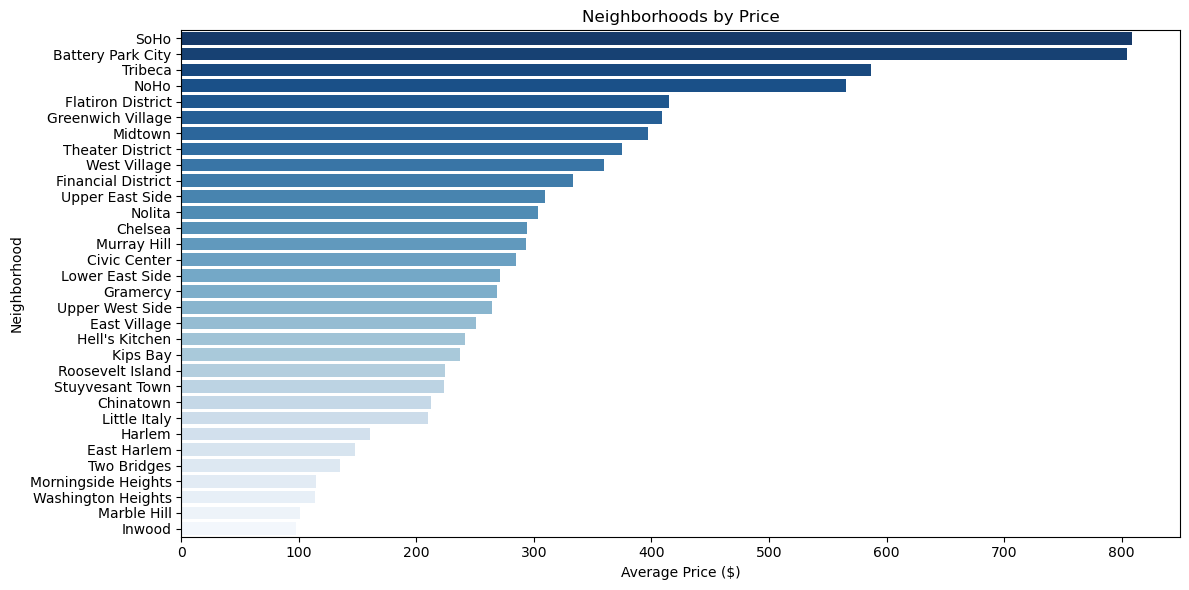

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=test, x='avg_price', y='neighbourhood_cleansed', palette='Blues_r')
plt.title("Neighborhoods by Price")
plt.xlabel("Average Price ($)")
plt.ylabel("Neighborhood")
plt.tight_layout()
plt.show()

C:\Users\erict\AppData\Local\Temp\ipykernel_20264\4017746293.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=test.tail(20), x='avg_price', y='neighbourhood_cleansed', palette='Blues_r')


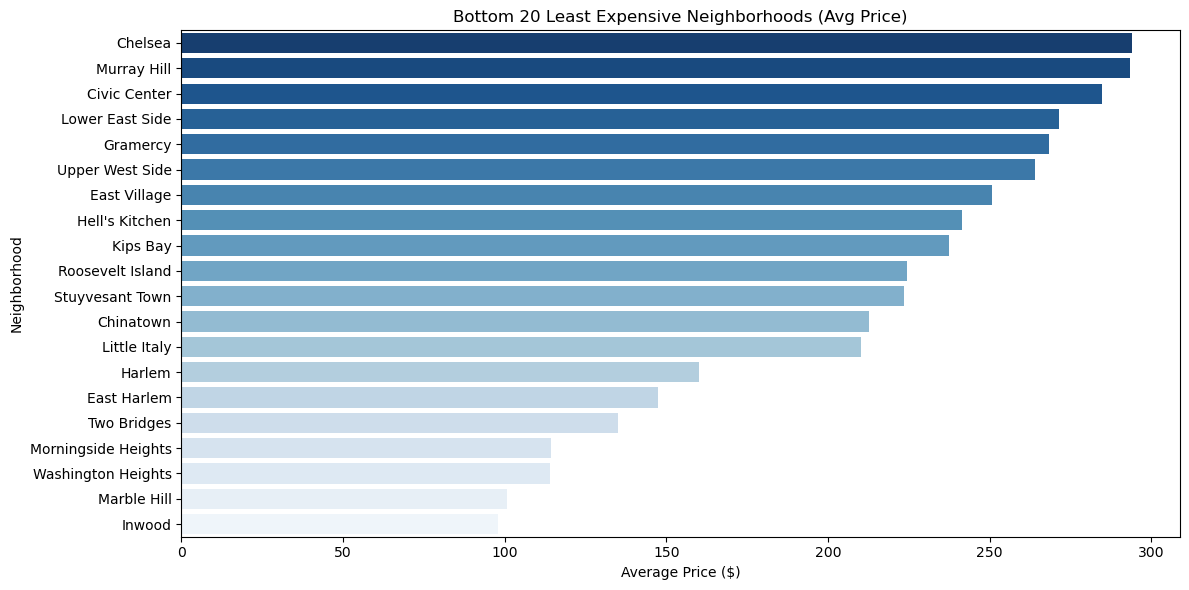

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=test.tail(20), x='avg_price', y='neighbourhood_cleansed', palette='Blues_r')
plt.title("Bottom 20 Least Expensive Neighborhoods (Avg Price)")
plt.xlabel("Average Price ($)")
plt.ylabel("Neighborhood")
plt.tight_layout()
plt.show()